# Twitter vs Stocks Change Data Analysis

## Data Cleaning Notebook

In [44]:
# Packages:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from urllib.request import urlopen
import json
import datetime
import numpy as np
import warnings
from textblob import TextBlob
import re
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

### Tweets DF, Sentimental Analysis and Tweets Cleaning Functions

In [45]:
# Function to clean Tweet Texts:
def cleantext(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text) # Remove Mentions&amp
    text = re.sub(r"#", "", text) # Remove Hashtags Symbol
    text = re.sub(r"RT[\s]+", "", text) # Remove Retweets
    text = re.sub(r"https?:\/\/\S+", "", text) # Remove The Hyper Link
    text = re.sub(r"&", "", text) # Remove The Hyper Link
    text = re.sub(r"amp", "", text) # Remove The Hyper Link
    
    return text

In [46]:
def Scalling(df_series,col_name):
    old_max = df_series.max(axis=0)
    old_min = df_series.min(axis=0)  
    OldRange = old_max - old_min  
    new_min = 0
    new_max = 1
    NewRange = (new_max - new_min)  
    df_series[col_name+"_scaled"] = (((df_series - old_min) * NewRange) / OldRange) + new_min
    return df_series[col_name+"_scaled"]

In [47]:
def Tweet_Clean(csv):

    # Pulling CSV with Twitter information. Check ceo_name.ipynb for data extraction:
    ceo_tweets = pd.read_csv(csv)
    columns_chosed = ['created_at','full_text','id','source','favorite_count','retweet_count']
    ceo_tweets = ceo_tweets[columns_chosed]

    # Filtering Dataframe for tweets since 2019:
    ceo_tweets["created_at"] = pd.to_datetime(ceo_tweets["created_at"]).dt.date
    ceo_tweets["created_at"] = pd.to_datetime(ceo_tweets["created_at"])
    ceo_tweets = ceo_tweets[ceo_tweets["created_at"]>='2019-01-01']

    # Clean The Text:
    ceo_tweets['full_text'] = ceo_tweets['full_text'].apply(cleantext)

    # Checking weekends:
    ceo_tweets["Day of Week"] = ceo_tweets['created_at'].dt.dayofweek
    ceo_tweets['orig_date'] = ceo_tweets['created_at']

    # Moving Tweets made during weekend to Monday:
    for i in range(ceo_tweets.shape[0]):
        if ceo_tweets['Day of Week'].loc[i] == 5:
            ceo_tweets['created_at'].loc[i] = ceo_tweets['created_at'].loc[i]+ datetime.timedelta(days=2)
        if ceo_tweets['Day of Week'].loc[i] == 6:
            ceo_tweets['created_at'].loc[i] = ceo_tweets['created_at'].loc[i]+ datetime.timedelta(days=1)

    # Get The Subjectivity
    def sentiment_analysis(ds):
        sentiment = TextBlob(ds['full_text']).sentiment
        return pd.Series([sentiment.subjectivity, sentiment.polarity])

    # Adding Subjectivity & Polarity
    ceo_tweets[["subjectivity", "polarity"]] = ceo_tweets.apply(sentiment_analysis, axis=1)

    # Aggregating Tweets by Date:
    ceo_tweets = (    
        ceo_tweets.groupby(["created_at"])
        .agg(
            Tweets=("full_text", "sum"),
            Agg_count=("full_text", "count"),
            Agg_retweet=("retweet_count", "sum"),
            Agg_favorite=("favorite_count", "sum"),
            Subjectivity_mean=("subjectivity", "mean"),
            Polarity_mean=("polarity", "mean"),
        )
        .reset_index()
    )
    ceo_tweets = ceo_tweets.rename(columns={"created_at":'Date'})

    #Scaling Polarity from -1 to 1 scale to 0 to 1 scale:    
    ceo_tweets["Polarity_scaled"] = Scalling(ceo_tweets["Polarity_mean"],"Polarity")
    
    # Calculating Delta for Polarity
    ceo_tweets["Polarity_delta"] = ceo_tweets["Polarity_scaled"]-ceo_tweets["Polarity_scaled"].shift()
    
    #Scaling Favorite_count and Retweet count
    ceo_tweets["Favorite_scaled"] = Scalling(ceo_tweets["Agg_favorite"],"Favorite")
    ceo_tweets["Retweet_scaled"] = Scalling(ceo_tweets["Agg_retweet"],"Retweet")
    
    

    return ceo_tweets

### Stock Data Cleaning Function

In [48]:
def Stock_Clean(stock):

    # Getting Data Stock prices. Source: Yahoo Finance.
    stock = pd.read_csv(stock)
    stock_df = stock[['Date','Close']]

    # Scaling Stock Delta Change to 0 to 1:
   
    old_max = stock_df["Close"].max(axis=0)
    old_min = stock_df["Close"].min(axis=0)  
    OldRange = old_max - old_min  
    new_min = 0
    new_max = 1
    NewRange = (new_max - new_min)  
    stock_df["Price_scaled"] = (((stock_df["Close"] - old_min) * NewRange) / OldRange) + new_min
    
    stock_df["Price_delta"] = stock_df["Price_scaled"]-stock_df["Price_scaled"].shift()
    
    # stock_df['Return'] = stock_df['Close']
    # stock_df['Return']= np.log(stock_df['Close']/stock_df['Close'].shift())
    stock_df = stock_df.rename(columns={"Close":'Price'})
    stock_df["Date"] = pd.to_datetime(stock_df["Date"]).dt.date
    stock_df["Date"] = pd.to_datetime(stock_df["Date"])
    
    return stock_df

### Function to Merge Stocks and Tweets DFs:

In [49]:
def Merging_dfs(stock_df,ceo_tweets):

    df_stock_tweets = stock_df.merge(ceo_tweets, how='left', on='Date')

    colnan = ['Agg_count','Agg_retweet','Agg_favorite','Subjectivity_mean','Polarity_mean','Polarity_scaled','Polarity_delta',"Favorite_scaled","Retweet_scaled"]
    
    for col in colnan:
        df_stock_tweets[col] = df_stock_tweets[col].fillna(0)

    df_stock_tweets['Tweets'] = df_stock_tweets['Tweets'].fillna('')
    
    return df_stock_tweets

## Word Cloud Function

In [55]:
def Word_Cloud(df_stock_tweets,ceo_name):
    allwords = " ".join([twts for twts in df_stock_tweets['Tweets']])
    wordCloud = WordCloud(width = 1000, height = 1000, random_state = 21, max_font_size = 119).generate(allwords)
    plt.figure(figsize=(20, 20), dpi=80)
    plt.imshow(wordCloud, interpolation = "bilinear")
    plt.axis("off")
    plt.savefig('images/'+ceo_name+'.png');

## Applying the functions:

: Tokyo2020 is here and we're proud to be giving you over 5,000 hours of content to watch on  thanks to our partn…  A huge thanks to all of our interns, who joined us this year from more than 400 universities and more than 40 countries! We’re glad you’re with us:) NationalInternDay 
We’ve long supported Dreamers, and I’m proud to join this coalition of CEOs to continue our call for legislation that provides a clear pathway to citizenship. In many parts of Southeast Asia and beyond, the impact of COVID remains severe. To help, we’re providing additional support to UNICEF ; the IFRC for healthcare equipment, as well as funding for public health caigns in the region.  Our bug bounty program is 10 yrs old now, rewarded nearly 30M dollars for over 2000 researchers, launching new program at  Thanks for all your contributions and happy bug hunting!
 Congrats! inspiring and glad to see the next steps!Among our research projects at Google - a time crystal, eternal change for no energy. Glad peo

,Date,Price,Price_scaled,Price_delta,Tweets,Agg_count,Agg_retweet,Agg_favorite,Subjectivity_mean,Polarity_mean,Polarity_scaled,Polarity_delta,Favorite_scaled,Retweet_scaled
0,2021-07-27,644.780029,0.000000,NaN,: Tokyo2020 is here and we're proud to be givi...,1.0,54.0,0.0,0.600000,0.500000,0.750000,0.174583,0.000000,0.000907
1,2021-07-28,646.979980,0.003760,0.003760,,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2021-07-29,677.349976,0.055663,0.051903,"A huge thanks to all of our interns, who joine...",3.0,442.0,5175.0,0.520370,0.329167,0.664583,-0.085417,0.016878,0.007544
3,2021-07-30,687.200012,0.072497,0.016834,"Our bug bounty program is 10 yrs old now, rewa...",3.0,673.0,4555.0,0.570442,0.283848,0.641924,-0.022659,0.014856,0.011496
4,2021-08-02,709.669983,0.110898,0.038402,So excited to share our new custom Google Tens...,1.0,3312.0,29227.0,0.602273,0.272727,0.636364,-0.005560,0.095320,0.056642


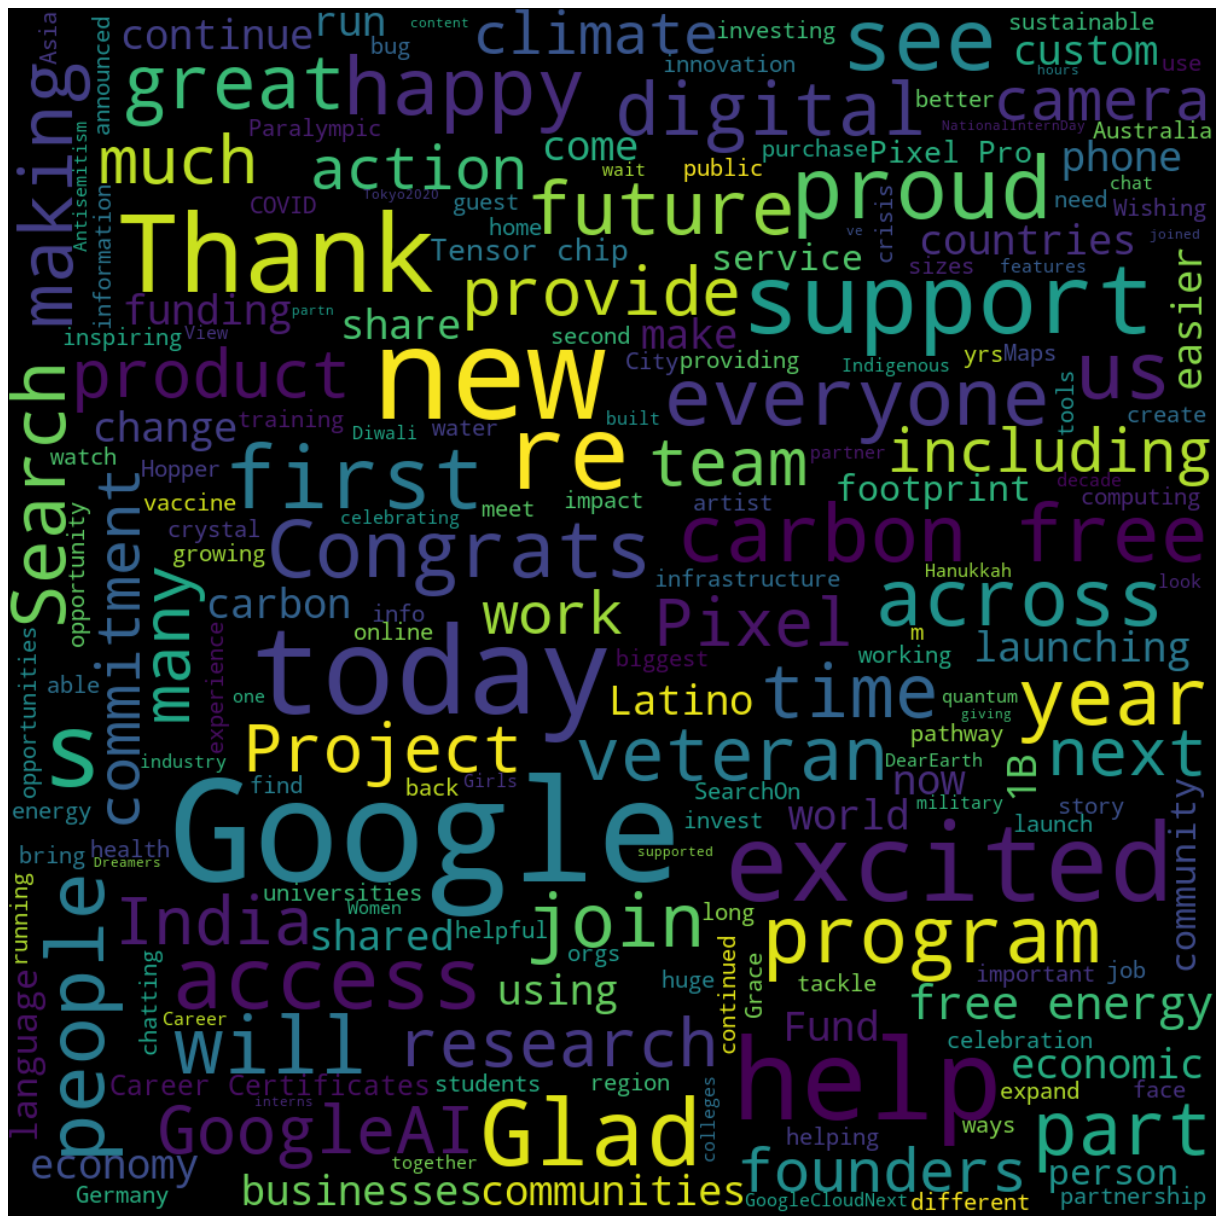

In [51]:
ceo_name = 'elonmusk'
stock_code = 'TSLA'

ceo_tweets = Tweet_Clean("data/raw/"+ceo_name+".csv")
stock_df = Stock_Clean("data/raw/"+stock_code+".csv")
df_stock_tweets = Merging_dfs(stock_df,ceo_tweets)

df_stock_tweets.to_csv('data/processed/'+ceo_name+'_cleaned.csv', index=False)
Word_Cloud(df_stock_tweets,ceo_name);
df_stock_tweets.head()

## Preliminary Plots

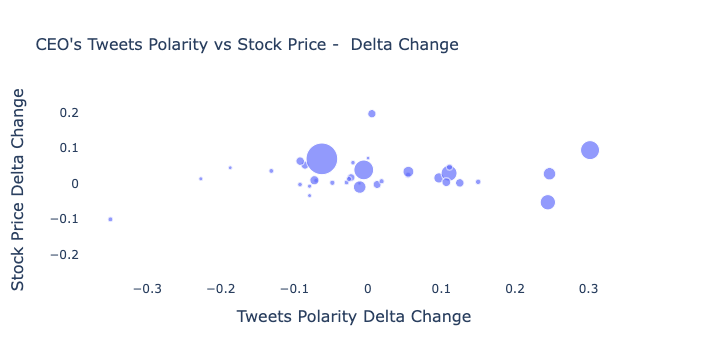

In [52]:
fig = go.Figure()
_ = fig.add_trace(go.Scatter(
    x= df_stock_tweets['Polarity_delta'],
    y= df_stock_tweets['Price_delta'],
    mode="markers",
    marker={"size": df_stock_tweets['Agg_favorite'], "sizemode": "area",
                                    "sizeref": 2*max(df_stock_tweets['Agg_favorite']/1000)},
    hovertemplate= "Number of Tweets per Day: %{x:.1f}<br>" +
    "Stock Price Change: %{y:.1f}<br>" +
    "Number of Likes: %{marker.size:,}" +
    "<extra></extra>"
))
fig.update_layout(
    plot_bgcolor="white",
    yaxis={"title": {"text": "Stock Price Delta Change", "font": {"size": 16}}},
    xaxis={"title": {"text": "Tweets Polarity Delta Change", "font": {"size": 16}}},
    # hovermode="x",
    title={'text': "CEO's Tweets Polarity vs Stock Price -  Delta Change", "font": {"size": 16}}
)
fig.show()

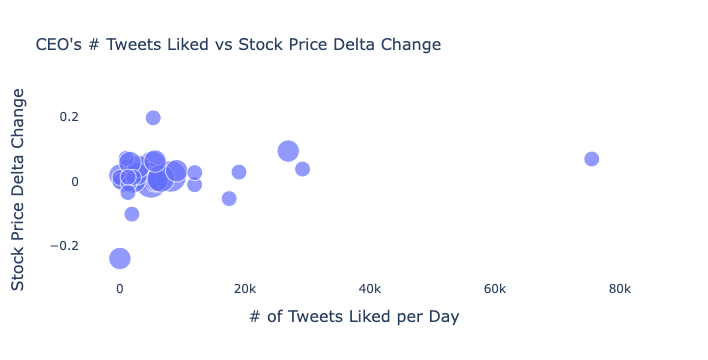

In [53]:
fig = go.Figure()
_ = fig.add_trace(go.Scatter(
    x= df_stock_tweets['Agg_favorite'],
    y= df_stock_tweets['Price_delta'],
    mode="markers",
    marker={"size": df_stock_tweets['Agg_count'], "sizemode": "area",
                                    "sizeref": 2*max(df_stock_tweets['Agg_count']/1000)},
    hovertemplate= "Number of Tweets Liked per Day: %{x:.1f}<br>" +
    "Stock Price Change: %{y:.1f}<br>" +
    "Number of Tweets: %{marker.size:,}" +
    "<extra></extra>"
))
fig.update_layout(
    plot_bgcolor="white",
    yaxis={"title": {"text": "Stock Price Delta Change", "font": {"size": 16}}},
    xaxis={"title": {"text": "# of Tweets Liked per Day", "font": {"size": 16}}},
    # hovermode="x",
    title={'text': "CEO's # Tweets Liked vs Stock Price Delta Change", "font": {"size": 16}}
)
fig.show()

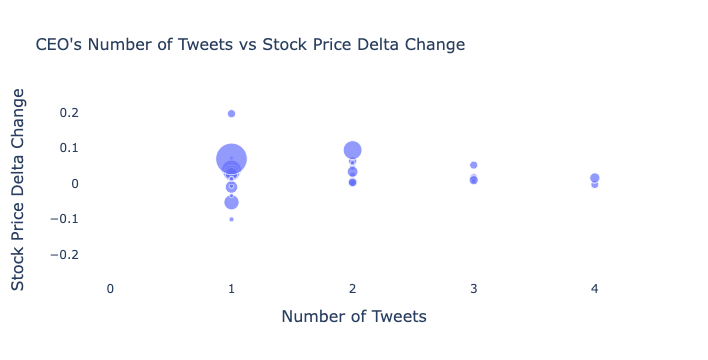

In [54]:
fig = go.Figure()
_ = fig.add_trace(go.Scatter(
    x= df_stock_tweets["Agg_count"],
    y= df_stock_tweets['Price_delta'],
    mode="markers",
    marker={"size": df_stock_tweets['Agg_favorite'], "sizemode": "area",
                                    "sizeref": 2*max(df_stock_tweets['Agg_favorite']/1000)},
    hovertemplate= "Polarity of Tweets: %{x:.1f}<br>" +
    "Stock Price Change: %{y:.1f}<br>" +
    "Number of Likes: %{marker.size:,}" +
    "<extra></extra>"
))
fig.update_layout(
    plot_bgcolor="white",
    # hovermode="x",
    xaxis={"title": {"text": "Number of Tweets", "font": {"size": 16}}},
    yaxis={"title": {"text": "Stock Price Delta Change", "font": {"size": 16}}},
    title={'text': "CEO's Number of Tweets vs Stock Price Delta Change", "font": {"size": 16}}
)
fig.show()